# Setup

Install previous version of pytorch due to compatibility issues with fastai

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 36.4MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


Import required packages

In [0]:
import h5py
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.vision import *
from fastai.metrics import error_rate

# Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

Authenticate to Google Drive to access dataset folder:

In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


General parameters and settings

In [0]:
mini_dataset_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192"
model_folder_path = "/content/drive/My Drive/document-classification/models/final-models"
model_name = "image-class_1488-288-192_valid-acc-67.36"

# Shape of the images in input to the CNN
cnn_image_shape = (224, 224)
# Number of images classes
n_classes = 16
# Batch size to be used in training
batch_size = 32

# Dataset loading

Read the csv files containing the training and test set images paths and labels into a single dataframe, distinguishing them by _is_valid_ value (True for the test set).

fast.ai evaluates the performance on the validation set only, so we need to replace it with the test set.

In [5]:
df_train = pd.read_csv(os.path.join(mini_dataset_path, "train-labels.csv"), names=["image", "label"])
df_test = pd.read_csv(os.path.join(mini_dataset_path, "test-labels.csv"), names=["image", "label"])
df_train["is_valid"] = False
df_test["is_valid"] = True
df_joined = pd.concat([df_train, df_test], ignore_index=True)
print(df_joined.head())
print(df_joined.tail())

                                 image  label  is_valid
0  train/0/0/0/0/94002065_94002066.tif     10     False
1         train/0/0/0/1/2074950097.tif     10     False
2      train/0/0/0/2/50284095-4103.tif      6     False
3           train/0/0/0/3/04003306.tif     10     False
4         train/0/0/0/4/2024967978.tif     11     False
                              image  label  is_valid
1675    test/0/1/8/7/0060212680.tif      0      True
1676    test/0/1/8/8/2023447951.tif      6      True
1677  test/0/1/8/9/corti0013630.tif      9      True
1678    test/0/1/9/0/2079066784.tif      2      True
1679    test/0/1/9/1/2047951324.tif      9      True


Create a custom ImageDataBunch starting from the previous dataframe.

In [0]:
data = (ImageList.from_df(df_joined, mini_dataset_path, cols="image")
        .split_from_df()
        .label_from_df()
        .transform(size=cnn_image_shape, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize())

# Model loading

In [7]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy,
                    model_dir=model_folder_path)
learn.load(model_name)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

# Performance calculation

Accuracy:

In [8]:
learn.validate()

[1.6241474, tensor(0.7188)]

Confusion matrix:

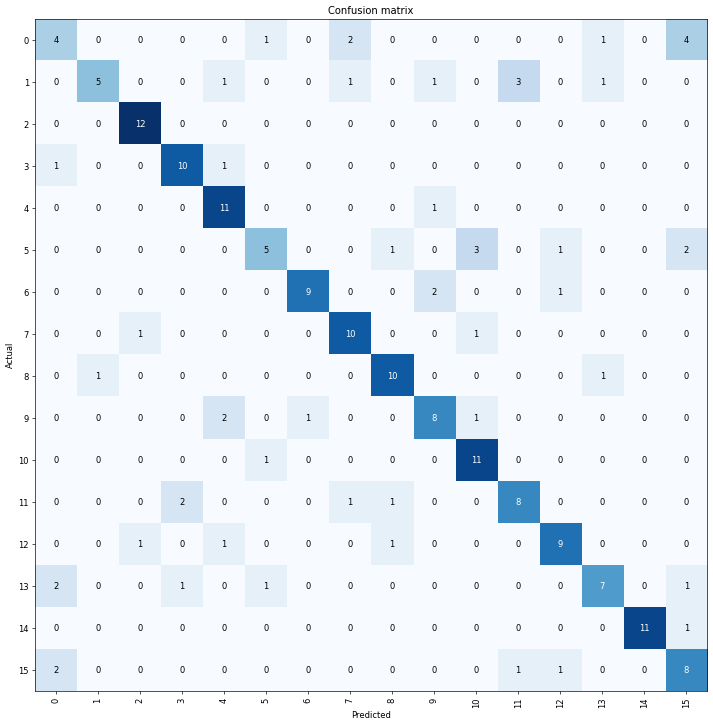

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Most confused categories:

In [10]:
interp.most_confused(min_val=3)

[(0, 15, 4), (1, 11, 3), (5, 10, 3)]

Show images that causes the worst classification errors:

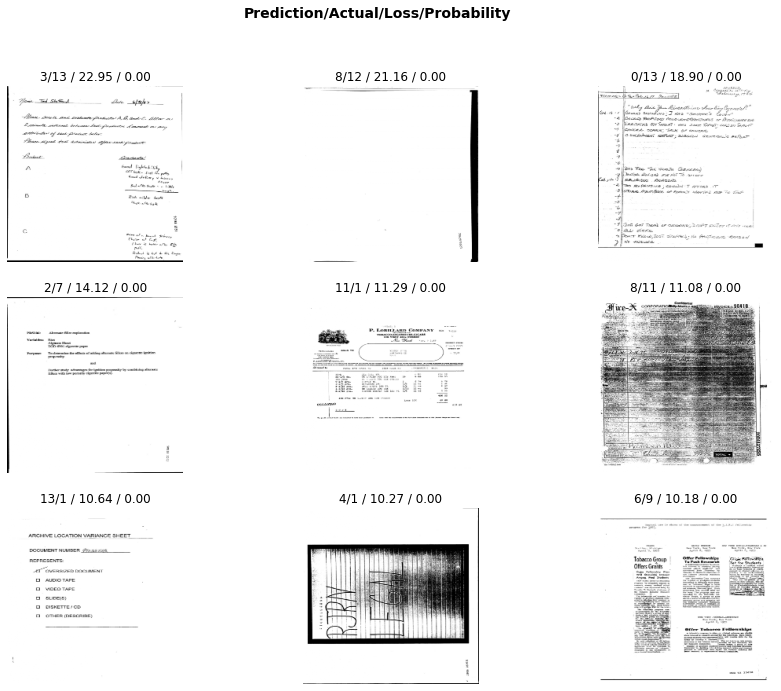

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

# Qualitative analysis of errors

Choose the images to analyze:

In [0]:
test_images = ["test/0/0/3/0/0001227554.tif", "test/0/0/0/6/50275320-5320.tif"]
test_labels = [13, 15]

Create the DataBunch to give to the network:

In [24]:
df_train = pd.read_csv(os.path.join(mini_dataset_path, "train-labels.csv"), names=["image", "label"])
df_test = pd.DataFrame(data={"image": test_images, "label": test_labels})

df_train["is_valid"] = False
df_test["is_valid"] = True
df_joined = pd.concat([df_train, df_test], ignore_index=True)
print(df_joined.tail())

data = (ImageList.from_df(df_joined, mini_dataset_path, cols="image", ignore_empty=True)
        .split_from_df()
        .label_from_df()
        .transform(size=cnn_image_shape, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=1)
        .normalize())

                                        image  label  is_valid
1485             train/1/4/8/5/2030169939.tif      1     False
1486  train/1/4/8/6/2057439010_2057439017.tif      7     False
1487               train/1/4/8/7/11006913.tif     10     False
1488              test/0/0/3/0/0001227554.tif     13      True
1489           test/0/0/0/6/50275320-5320.tif     15      True


Insert the new DataBunch into the learner:

In [29]:
learn.data = data

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

Make predictions:

In [30]:
val_preds, val_targets = learn.get_preds()
val_preds = torch.argmax(val_preds, dim=1)
df_results = pd.DataFrame(data={"Predicted": val_preds, "Ground Truth": val_targets})
print(df_results)

   Predicted  Ground Truth
0          4            13
1         15            15
